# přehled

- strukturování datasetu
- exploratory analysis
- příprava datasetu pro trénování modelu
- finetuning a distil-BERT model 
- demostrace natrenovaneho modelu

In [1]:
import os
import numpy as np
import pandas as pd
import ndjson

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

/Users/au582299/.pyenv/versions/3.9.7/envs/szn_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset
Recenze jídel z Amazonu.  
Získáno z http://snap.stanford.edu/data/web-FineFoods.html.  

#### download
`$ bash download_data.sh`

#### struktura
Dataset je dlouhý textový soubor, ve kterém jsou pozorování (recenze) oddělena dvojitými novými řádky.  
Jedna recenze vypadá takto:

```
product/productId: B001E4KFG0
review/userId: A3SGXH7AUHU8GW
review/profileName: delmartian
review/helpfulness: 1/1
review/score: 5.0
review/time: 1303862400
review/summary: Good Quality Dog Food
review/text: I have bought several of the Vitality canned dog food products and have
found them all to be of good quality. The product looks more like a stew than a
processed meat and it smells better. My Labrador is finicky and she appreciates this
product better than most.
```

Prvním krokem bude strukturování souboru dat do `List[dict]`

In [2]:
# import dataset
dataset_path = os.path.join("dat", "finefoods.txt")
with open(dataset_path, encoding="iso-8859-1") as fin:
    finefoods_unstruct = fin.read()

# structure dataset from a long string to a list of dict
ff = [
    # text before the first colon is key, everything after is value
    {
        line.split(": ")[0]: ": ".join(line.split(": ")[1:])
        # key-value pairs are separated by a single newline
        for line in obs.split("\n")
    }  
    # observations are separated by double newline
    for obs in finefoods_unstruct.split("\n\n") if obs
    ]

# length is same as reported on http://snap.stanford.edu/data/web-FineFoods.html
len(ff)

568454

Některé recenze jsou špatně naformátovány.  
Příklad:

In [3]:
# good observation (standard format)
ff[0]

{'product/productId': 'B001E4KFG0',
 'review/userId': 'A3SGXH7AUHU8GW',
 'review/profileName': 'delmartian',
 'review/helpfulness': '1/1',
 'review/score': '5.0',
 'review/time': '1303862400',
 'review/summary': 'Good Quality Dog Food',
 'review/text': 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'}

In [4]:
# bad observation (random value without a key)
ff[351182]


{'product/productId': 'B003XBBAUM',
 'review/userId': 'A2HVY3YRSJR5NF',
 'review/profileName': 'J. Facey "J.F., CA',
 'I am a voracious reader/li...': '',
 'review/helpfulness': '2/2',
 'review/score': '5.0',
 'review/time': '1332633600',
 'review/summary': 'The absolute best - taste better than brown sugar',
 'review/text': 'I recently bought this sugar alternative and I am completely blown away! I have fibromyalgia, multiple food allergies/sensitivities and so many thing make me feel bad including exacerbating my pain. This does not have any negative effects on me whatsoever. The taste is out of this world! I am tempted to just eat it. This one is a winner! A little secret - I found it much cheaper at Whole Foods market.'}

Převod na data frame (tabulkojiní datová struktura).  
Budeme moci odstranit pouze chybně naformátované řádky, ale necháme si recenzi ke které patří.

In [5]:
df = pd.DataFrame(ff)

# drop misformated parts of the review
faulty_cols = [8, 9, 10, 11]
df = df.drop(df.columns[faulty_cols], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   product/productId   568454 non-null  object
 1   review/userId       568454 non-null  object
 2   review/profileName  568454 non-null  object
 3   review/helpfulness  568454 non-null  object
 4   review/score        568454 non-null  object
 5   review/time         568454 non-null  object
 6   review/summary      568454 non-null  object
 7   review/text         568454 non-null  object
dtypes: object(8)
memory usage: 34.7+ MB


Converting variables to the right data type to make working with them easier.  
- review/score: str -> int
- review/time: unix timestamp -> yyyy-mm-dd
- expand review/helpfulness to be helpful

In [6]:
# review score to int
df["review/score"] = df["review/score"].astype(float).astype(int)

# unix timestamp to date (all the dates are on midnight, so we only have daily-resolution)
# FIXME convert back to string before splitting
df["review/time"] = pd.to_datetime(df["review/time"], unit="s")

# split review helpfulness into two numbers
review_helpful = [obs.split("/") for obs in df["review/helpfulness"].tolist()]
# proportion of votes that think review was helpful
df["review/helpful_prop"] = [
    int(n_hlp) / int(n_total) if int(n_total) > 0 else 0
    for n_hlp, n_total in review_helpful
]
# total number of helpfulness votes
df["review/helpful_n_total"] = [int(obs[1]) for obs in review_helpful]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   product/productId       568454 non-null  object        
 1   review/userId           568454 non-null  object        
 2   review/profileName      568454 non-null  object        
 3   review/helpfulness      568454 non-null  object        
 4   review/score            568454 non-null  int64         
 5   review/time             568454 non-null  datetime64[ns]
 6   review/summary          568454 non-null  object        
 7   review/text             568454 non-null  object        
 8   review/helpful_prop     568454 non-null  float64       
 9   review/helpful_n_total  568454 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 43.4+ MB


### exploratory analysis
ačkoli dataset zahrnuje období od října 1999 do října 2012, většina recenzí je z konce tohoto období.

<AxesSubplot:xlabel='review/time', ylabel='Count'>

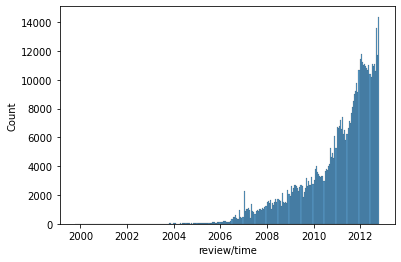

In [8]:
sns.histplot(x=df['review/time'])

Nezdá se, že by na počet hvězdiček měl vliv rok.  
V prvních letech je příliš málo recenzí.

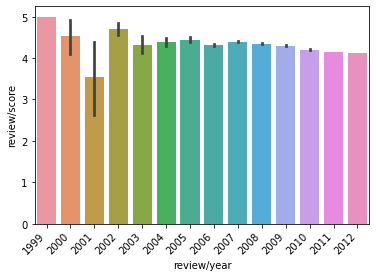

In [9]:
df_time = df.copy()

df_time["review/year"] = [
    int(date[0:4]) for date in df_time["review/time"].dt.strftime("%Y-%m-%d").tolist()
]

fig = sns.barplot(x=df_time["review/year"], y=df_time["review/score"])
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()


Zdá se, že průměrná délka recenzí je v průběhu let také stabilní.  
Je možné, že se průměrná délka recenze nebo počet udělených hvězdiček mění v důsledku sezónních trendů (například Vánoc).

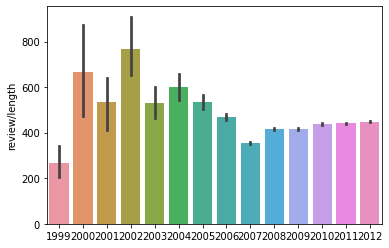

In [10]:
df_time["review/length"] = [len(text) for text in df_time["review/text"].tolist()]

fig = sns.barplot(x=df_time["review/year"], y=df_time["review/length"])
fig.set(xlabel=None)
plt.show()

I když v průběhu let vidíme více odchylek.

/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_80580/3713732775.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment="right")


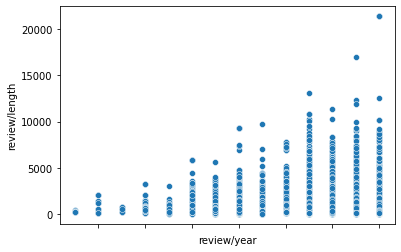

In [11]:
fig = sns.scatterplot(x=df_time["review/year"], y=df_time["review/length"])
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()

# Příprava datasetu pro trénování modelu

- odstranění chybějících hodnot
- deduplikace
- sloučení textových sloupců
- binarizace outcome variable (`review/score`)


### chybějící hodnoty
Občas se vyskytují chybějící hodnoty v `review/summary`, což je jeden z textových sloupců.   

In [12]:
# missing values are indicated as either "N/A" or "n/a"
na_uppercase = df['review/summary'].value_counts()['N/A']
na_lowercase = df['review/summary'].value_counts()['n/a']

print(f"N/A count: {na_uppercase} \nn/a count: {na_lowercase}")


N/A count: 26 
n/a count: 1


In [13]:
# remove rows with NaN in text fields
df_nonan = df.replace("N/A", np.nan).replace("n/a", np.nan).dropna()
len(df_nonan)

568427

### deduplikace
Přibližně třetina recenzí v datasetu má duplicitní text (`review/text`) a ještě více z nich má duplicitní titulek (`review/summary`).  
Recenze s duplicitním textem (`recenze/text`) budou odstraněny v pokusu zmenšit riziko overfittingu na těchto příkladech. 

Duplicity v `review/summary` jsou však srozumitelnější.  
Tyto texty jsou většinou krátké (často jednoslovné), nedá se v nich udělat tolik kombinací.
Duplicity v `review/summary` budou ponechány.  

Konečné texty použité k trénování modelu nebudou obsahovat žádné duplicity, protože tato dvě textová pole budou později sloučena.

In [14]:
n_duplicates_text = df_nonan['review/text'].duplicated().sum()
n_duplicates_summary = df_nonan['review/summary'].duplicated().sum()
print(
    f"n duplicates in review/text: {n_duplicates_text}",
    '\n'
    f'n_duplicates in review/summary: {n_duplicates_summary}'
    )

n duplicates in review/text: 174851 
n_duplicates in review/summary: 272685


In [15]:
# top 5 summaries used in the reviews
(df_nonan
    .groupby('review/summary')
    .size()
    .sort_values(ascending=False)
    .head()
)

review/summary
Delicious!       2462
Delicious        2316
Yummy!           1594
Yummy            1268
Great product    1091
dtype: int64

In [16]:
# remove NaN & duplicates
df_deduped = df_nonan.drop_duplicates(subset=["review/text"])
df_deduped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393576 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   product/productId       393576 non-null  object        
 1   review/userId           393576 non-null  object        
 2   review/profileName      393576 non-null  object        
 3   review/helpfulness      393576 non-null  object        
 4   review/score            393576 non-null  int64         
 5   review/time             393576 non-null  datetime64[ns]
 6   review/summary          393576 non-null  object        
 7   review/text             393576 non-null  object        
 8   review/helpful_prop     393576 non-null  float64       
 9   review/helpful_n_total  393576 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 33.0+ MB


### sloučení textových sloupců
Spojení obou textových polí do jednoho sloupce by mohlo být vhodné pro vytváření předpovědí.  
`review/summary` nabízí jen krátký prostor - zákazník vyjadřuje verdikt v několika slovech.  
Na druhou stranu `review/text` nabízí podrobnější popis.

U `review/summary` lze očekávat, že texty budou nejednoznačné, duplikované & příliš krátké na to, aby na jejich základě bylo možné provést spolehlivou klasifikaci.  
V kombinaci s texty však získáme jak výpověďní hodnotu `review/summary`, tak specifičnost `review/text`.

In [17]:
# summary + text in new col
df_deduped["review/all_text"] = df_deduped["review/summary"] + "\n" + df_deduped["review/text"]

/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_80580/3300223837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped["review/all_text"] = df_deduped["review/summary"] + "\n" + df_deduped["review/text"]


### binarizace
Zákazníci udělují produktům hodnocení od 1 do 5 hvězdiček.  
Naprostá většina recenzí uděluje 5 hvězdiček.  
To vytváří velmi nevyvážený dataset.  

Proto:
- Recenze s 1, 2, 3 hvězdami budou NEGATIVNÍ.  
- Recenze s 4, 5 hvězdami budou POZITIVNÍ.

<AxesSubplot:xlabel='review/score', ylabel='count'>

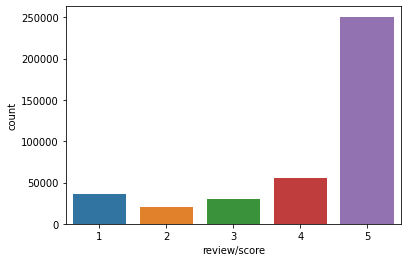

In [18]:
sns.countplot(x=df_deduped["review/score"])

/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_80580/2417537417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped["label"] = [score2label[score] for score in df_deduped["review/score"].tolist()]


<AxesSubplot:xlabel='label', ylabel='count'>

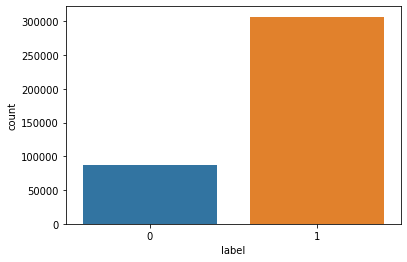

In [19]:
# binarize outcome variable
score2label = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}

df_deduped["label"] = [score2label[score] for score in df_deduped["review/score"].tolist()]
sns.countplot(x=df_deduped["label"])

I když dataset je stále velmi nevyvážený, toto bude muset stačit.

### train-test split
Pomocí argumentu `stratify` zajistíme, aby byl poměr pozitivních a negativních recenzí v trénovací a testovací složce přibližně stejný.

In [20]:
# convert dates into a string again (datetimes can't be parsed by the model trainer)
df_deduped['review/time'] = df_deduped['review/time'].dt.strftime('%Y-%m-%d')

# train test split
X_train, X_test = train_test_split(
    df_deduped, test_size=0.3, stratify=df_deduped["label"], random_state=891117
)

# save for model training
X_train.to_csv("dat/train.csv", index=False)
X_test.to_csv("dat/test.csv", index=False)

/var/folders/_1/x3y6hbdn5ljg_g6fr5kj88bs87mgrt/T/ipykernel_80580/1023556878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['review/time'] = df_deduped['review/time'].dt.strftime('%Y-%m-%d')


# finetuning

Způsobem, jak vytvořit dobrý klasifikátor, je použití přenosového učení (transfer learning).  
Tímto způsobem můžeme použít model, který již byl natrénován na mnohonásobně větším datasetu a vyladit jej pro danou úlohu. 


### distilBERT
Jako základní model jsem zvolil [distilBERT](https://huggingface.co/distilbert-base-uncased).  
Protože:
- feature engineering je už zahrnuto v modelu a nemusíme tak vymýšlet lemmatizaci, tf-idf vektorizaci, atd.
- je to menší verze modelu BERT, ale stále téměř stejně přesná. Méně parametrů modelu znamená rychlejší (levnější) trénování a inferenci.
- Modely typu BERT jsou v současné době nejpřesnější v řadě úloh klasifikace textu (https://paperswithcode.com/task/sentiment-analysis)
    - a konkrétně při klasifikaci sentimentu recenzí z Amazonu (https://paperswithcode.com/sota/sentiment-analysis-on-amazon-review-polarity)

### trénování
Jelikož trénování modelu zabere pár hodin, nezahrnul jsem jej v tomto notebooku.  
Skript pro trénování: `src/finetune_distilbert.py`.  
Výsledný model jsem nahrál na [huggingface](https://huggingface.co/janko/distilbert-uncased-finefoods).

Paramtery pro trénování zůstaly stejné jako v základním modelu, s vyjímkou:
- n epochs: 5
- learning rate: 2e-5

Pozbytek notebooku budu používat svůj natrénovaný model.

In [21]:
# load fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("janko/distilbert-uncased-finefoods")
model = AutoModelForSequenceClassification.from_pretrained("janko/distilbert-uncased-finefoods", from_tf=True)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [22]:
# predict labels of reviews in the test set
if not os.path.exists('dat/test_predictions.ndjson'):

    predictions = []
    for text in tqdm(X_test["review/all_text"].tolist()):
        predictions.extend(
            classifier(text, padding=True, truncation=True)
        )

    with open('dat/test_predictions.ndjson', 'w') as fout:
        ndjson.dump(predictions, fout)

else:
    # if predictions were already made, load instead
    with open('dat/test_predictions.ndjson') as fin:
        predictions = ndjson.load(fin)


In [23]:
# convert predictions to class names
pred2class = {'LABEL_0': 'NEGATIVE', 'LABEL_1': 'POSITIVE'}
y_pred = [pred2class[pred['label']] for pred in predictions]

# convert true labels to class names
label2class = {0: "NEGATIVE", 1: "POSITIVE"}
y_true = [label2class[lab] for lab in X_test['label'].tolist()]

Model má 96% přesnost na testovacím datasetu.  

Pozitivní recenze jsou klasifikovány s větší jistotou, než negativní.  
To může být z několika důvodů:
- nerovnovážné zastoupení obou kategorií
- negativní recenze mohou být různorodější, protože např. 3 hvězdy jsou stále považovány za negativní

In [24]:
# evaluate test set predictions
performance_table = classification_report(y_true, y_pred)
print(performance_table)

              precision    recall  f1-score   support

    NEGATIVE       0.91      0.92      0.92     26045
    POSITIVE       0.98      0.97      0.98     92028

    accuracy                           0.96    118073
   macro avg       0.94      0.95      0.95    118073
weighted avg       0.96      0.96      0.96    118073



# evaluace a příklady inference

Jak si model poradil s nejednoznačnými recenzemi (2, 3, 4 hvězdy)?  

Celkově dobře. Predikce se zřetelně mění mezi 3. a 4. hvězdou, v souladu s tím, jak byly kategorie definovány.  
Model největší jistotu v extrémech (1 nebo 5 hvězd).  
Nejméně jisté jsou predikce 3-hvězdičkových recenzí.  

Zajímavá je četnost negativních predikcí pro 4-hvězdičkové recenze.  
Možná zákazníci v těchto recenzích více zmiňují chyby produktu, aby vysvětlili proč nedávají 5 hvězd.


<AxesSubplot:xlabel='review/score', ylabel='prediction'>

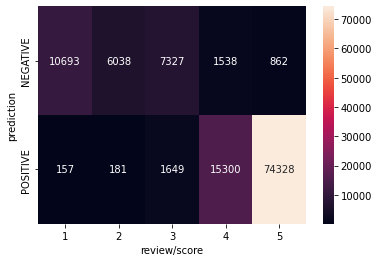

In [25]:
df_viz = X_test.copy()
df_viz['prediction'] = y_pred

confusion_mat = (df_viz
    .groupby(['prediction', 'review/score'])
    .size()
    .reset_index(name='n')
    .pivot("prediction", "review/score", "n")
)

sns.heatmap(data=confusion_mat, annot=True, fmt="d")

Predikce z vymyšlených vět ukazuje, že model má určitý vhled do polarity recenzí a zvládne i negace.

In [26]:
# positive
classifier('This oatmeal tastes good')

[{'label': 'LABEL_1', 'score': 0.9844746589660645}]

In [27]:
# negative
classifier("This oatmeal doesn't taste good")

[{'label': 'LABEL_0', 'score': 0.9976890087127686}]

In [28]:
# positive
classifier('I would recommend this product')

[{'label': 'LABEL_1', 'score': 0.9779092073440552}]

In [29]:
# negative
classifier('I would not recommend this product')

[{'label': 'LABEL_0', 'score': 0.9986770749092102}]

Zdá se ale, že model má problém s klasifikací sarkasmů.

In [30]:
# positive
classifier('What a "great" product...')

[{'label': 'LABEL_1', 'score': 0.9972133040428162}]

In [31]:
# positive
classifier('What a great product!!!')

[{'label': 'LABEL_1', 'score': 0.9995976090431213}]

Dále se zdá, že se model z recenzí naučil některé předpojatosti.

In [32]:
# positive
classifier('This product was made in the USA')

[{'label': 'LABEL_1', 'score': 0.7475714087486267}]

In [33]:
# negative
classifier('This product was made in China')

[{'label': 'LABEL_0', 'score': 0.9829034209251404}]